### start

In [9]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

import sage_wallet_insights.model_evaluation as sime

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.wallet_script_modeler as sm
import sage_wallet_modeling.workflow_orchestrator as wo

import script_modeling.entry_helpers as h
# import script_modeling.temporal_cv_model_entry as tme


# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    ucv, s3u,
    sime,
    wm, sm, wo,
    h,
    wime,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        # 'config_models',
        'sage_wallet_insights',
        'sage_wallet_modeling',
        'script_modeling',
        'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

[10/Aug/25 21:37:14] INFO [utils.export_code:1672] Consolidation complete. All files are saved in temp/sagemaker_code.py
[10/Aug/25 21:37:14] MILESTONE [1067068951.<module>:136] Good morning, let's get to work


# Model Training

## Concatenated Model Sequence

#### load all local data

In [10]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.load_all_training_data()

[10/Aug/25 21:37:17] INFO [workflow_orchestrator.load_all_training_data:99] Auto-detected date_suffixes from config: ['220913', '221013', '221112', '221212', '230111', '230210', '230312', '230411', '230511', '230610', '230710', '230809', '230908', '231008', '231107', '231207', '240106', '240306', '240505', '240704', '240902', '241101', '241231', '240205', '240405', '240604', '240803', '241002', '241201', '250130', '250301', '250331', '250430', '250530']
[10/Aug/25 21:37:17] MILESTONE [workflow_orchestrator.load_all_training_data:116] <PROD> Loading training data for 34 periods: ['220913', '221013', '221112', '221212', '230111', '230210', '230312', '230411', '230511', '230610', '230710', '230809', '230908', '231008', '231107', '231207', '240106', '240306', '240505', '240704', '240902', '241101', '241231', '240205', '240405', '240604', '240803', '241002', '241201', '250130', '250301', '250331', '250430', '250530']
[10/Aug/25 21:37:22] INFO [workflow_orchestrator.load_all_training_data:13

#### preprocess and concatenate

In [11]:
results = workflow_orch.preprocess_all_training_data()

[10/Aug/25 21:37:22] INFO [workflow_orchestrator.preprocess_all_training_data:154] Preprocessing 34 date periods...
[10/Aug/25 21:37:22] INFO [wallet_preprocessor.preprocess_training_data:74] Starting preprocessing for SageMaker XGBoost compatibility...
[10/Aug/25 21:37:22] INFO [wallet_preprocessor._handle_missing_values:243] Filled NaN values in 94 columns for x_train.
[10/Aug/25 21:37:23] INFO [wallet_preprocessor._save_preprocessed_df:415] Saved preprocessed train split to ../s3_uploads/wallet_training_data_preprocessed/dda_951_eval_all_pr58/220913/train.csv
[10/Aug/25 21:37:23] INFO [wallet_preprocessor._save_preprocessed_df:415] Saved preprocessed train_y split to ../s3_uploads/wallet_training_data_preprocessed/dda_951_eval_all_pr58/220913/train_y.csv
[10/Aug/25 21:37:23] INFO [wallet_preprocessor.preprocess_training_data:123] Preprocessed train: 6,219 rows × 231 cols.
[10/Aug/25 21:37:23] INFO [wallet_preprocessor._handle_missing_values:243] Filled NaN values in 94 columns for x

In [12]:
workflow_orch.concatenate_all_preprocessed_data(repreprocess_offsets=False)

[10/Aug/25 21:41:07] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:200] Loading preprocessed training data...
[10/Aug/25 21:41:32] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:203] Beginning concatenation of preprocessed data...
[10/Aug/25 21:43:32] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:264] Saved concatenated train.csv.gz with 450134 rows to ../s3_uploads/wallet_training_data_concatenated/dda_951_eval_all_pr58/train.csv.gz
[10/Aug/25 21:43:40] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:264] Saved concatenated eval.csv.gz with 33299 rows to ../s3_uploads/wallet_training_data_concatenated/dda_951_eval_all_pr58/eval.csv.gz
[10/Aug/25 21:44:07] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:264] Saved concatenated test.csv.gz with 99891 rows to ../s3_uploads/wallet_training_data_concatenated/dda_951_eval_all_pr58/test.csv.gz
[10/Aug/25 21:44:38] INFO [workflow_orchestrator.concatenate_all_preprocess

#### inspect features

In [ ]:
local_s3 = sage_wallets_config['training_data']['local_s3_root']
local_dir = sage_wallets_config['training_data']['local_directory']
local_dir = f"{local_dir}_dev" if sage_wallets_config['training_data']['dataset'] == 'dev' else local_dir
df = pd.read_csv(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/eval.csv')
with open(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)

df.columns = metadata['feature_columns']
u.display_full(df.describe().T)

#### upload

In [13]:
concat_uris = workflow_orch.upload_concatenated_training_data(
    overwrite_existing=True,
    # splits=['val']
)

[10/Aug/25 21:44:54] INFO [workflow_orchestrator.upload_concatenated_training_data:376] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[10/Aug/25 21:44:54] INFO [workflow_orchestrator.upload_concatenated_training_data:379] Uploading concatenated splits in parallel with 4 threads...
[10/Aug/25 21:44:54] INFO [workflow_orchestrator._upload_split:400] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-951-eval-al-pr58/eval.csv.gz', proceeding with upload...
[10/Aug/25 21:44:54] INFO [workflow_orchestrator._upload_split:400] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-951-eval-al-pr58/test.csv.gz', proceeding with upload...
[10/Aug/25 21:44:54] INFO [workflow_orchestrator._upload_split:400] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-951-eval-al-pr58/val.csv.gz', proceeding with upload...
[10/Aug/25 21:44:54] I

### Epoch Shifts Sequence

#### train all epoch shifts

In [14]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_all_epoch_shift_models(concat_uris)

[10/Aug/25 21:57:17] INFO [workflow_orchestrator.upload_concatenated_training_data:376] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[10/Aug/25 21:57:17] INFO [workflow_orchestrator.upload_concatenated_training_data:379] Uploading concatenated splits in parallel with 4 threads...
[10/Aug/25 21:57:17] INFO [workflow_orchestrator._upload_split:393] File exists, skipping upload of concatenated split 'eval': training-data-concatenated/dda-951-eval-al-pr58/eval.csv.gz
[10/Aug/25 21:57:17] INFO [workflow_orchestrator._upload_split:393] File exists, skipping upload of concatenated split 'test': training-data-concatenated/dda-951-eval-al-pr58/test.csv.gz
[10/Aug/25 21:57:17] INFO [workflow_orchestrator._upload_split:393] File exists, skipping upload of concatenated split 'val': training-data-concatenated/dda-951-eval-al-pr58/val.csv.gz
[10/Aug/25 21:57:17] INFO [workflow_orchestrator._upload_split:393] Fil

2025-08-11 04:57:20 Starting - Starting the training job...
2025-08-11 04:57:52 Downloading - Downloading input data...
2025-08-11 04:58:12 Downloading - Downloading the training image...
2025-08-11 04:58:32 Training - Training image download completed. Training in progress..../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-08-11 04:59:14.572 ip-10-0-186-70.us-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-08-11 04:59:14.589 ip-10-0-186-70.us-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-08-11:04:59:14:INFO] Imported framework sagemaker_xgboost_container.training
[2025-08-11:04:59:14:INFO] No GPUs detecte

[10/Aug/25 22:02:47] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-al-pr58/sh0/wscr-dda-951--sh0-0810-215718/output/model.tar.gz
[10/Aug/25 22:02:47] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=0
[10/Aug/25 22:02:47] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:497] Epoch shift training complete: 1/1 models successful


#### predict all epoch_shifts

In [15]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

workflow_orch.predict_all_epoch_shifts()

[10/Aug/25 22:02:48] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:663] Starting predictions for 1 epoch shifts using 10 threads...
[10/Aug/25 22:02:49] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0810-215718): s3://wallet-script-models/model-outputs/dda-951-eval-al-pr58/sh0/wscr-dda-951--sh0-0810-215718/output/model.tar.gz
[10/Aug/25 22:02:49] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[10/Aug/25 22:02:49] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[10/Aug/25 22:02:49] INFO [session.submit:4105] Creating model with name: wscr-dda-951--sh0-0810-215718
[10/Aug/25 22:02:49] INFO [session.submit:4105] Creating model with name: wscr-dda-951--sh0-0810-215718
[10/Aug/25 22:02:50] WARNING [session.submit:4116] Using already existing model: wscr-dda-951--sh0-0810-215718
[10/Aug/25 22:02:50] INFO [wallet_modeler._execute_batch_transform:627] Starting batch transform job

.......................................................................................................................!

[10/Aug/25 22:07:55] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-al-pr58/sh0/wallet-scoring-sh0-220250-concat-val/val.csv.gz.out


[10/Aug/25 22:07:56] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all_pr58/sh0/val.csv.out.
[10/Aug/25 22:07:56] INFO [wallet_modeler.None:296] (5m6s) Completed predict_with_batch_transform.


.!

[10/Aug/25 22:08:05] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-al-pr58/sh0/wallet-scoring-sh0-220250-concat-test/test.csv.gz.out


[10/Aug/25 22:08:05] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all_pr58/sh0/test.csv.out.
[10/Aug/25 22:08:05] INFO [wallet_modeler.None:296] (5m16s) Completed predict_with_batch_transform.
[10/Aug/25 22:08:05] INFO [wallet_modeler.None:353] (5m16s) Completed batch_predict_test_and_val.
[10/Aug/25 22:08:05] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:687] ✓ Completed predictions for epoch_shift=0
[10/Aug/25 22:08:05] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:694] Epoch shift predictions complete: 1/1 successful


{0: {'test': {'transform_job_name': 'wallet-scoring-sh0-220250-concat-test',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-951-eval-al-pr58/sh0/wallet-scoring-sh0-220250-concat-test/test.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-951-eval-al-pr58/test.csv.gz'},
  'val': {'transform_job_name': 'wallet-scoring-sh0-220250-concat-val',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-951-eval-al-pr58/sh0/wallet-scoring-sh0-220250-concat-val/val.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-951-eval-al-pr58/val.csv.gz'},
  'model_uri': 's3://wallet-script-models/model-outputs/dda-951-eval-al-pr58/sh0/wscr-dda-951--sh0-0810-215718/output/model.tar.gz',
  'training_job_name': 'wscr-dda-951--sh0-0810-215718',
  'epoch_shift': 0}}

In [16]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = workflow_orch.build_all_epoch_shift_evaluators()


[10/Aug/25 22:08:05] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:740] Building evaluators for 1 epoch shifts using 4 threads...
[10/Aug/25 22:08:06] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0810-215718): s3://wallet-script-models/model-outputs/dda-951-eval-al-pr58/sh0/wscr-dda-951--sh0-0810-215718/output/model.tar.gz


Unique offset_date values in data: [1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0]
Target offset_days after 0 shift: [1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830]
Unique offset_date values in data: [1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0]
Target offset_days after 0 shift: [1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830]
Starting with 99,891 rows before custom filtering
Column stats for trading|total_volume|w1:
  Min: 0
  Max: 22,580,968
Filter 'trading|total_volume|w1' min 500: removed 19,107 rows
Filter 'trading|total_volume|w1' max 10000000: removed 188 rows
Filter 'trading|total_volume|w1' total impact: removed 19,295 rows (80,596 remaining)
Custom filtering complete: 19,295 rows removed (19.3%), 80,596 rows remaining
Unique offset_date values in data: [1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target of

[10/Aug/25 22:08:18] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:757] ✓ Built evaluator for epoch_shift=0
[10/Aug/25 22:08:18] INFO [workflow_orchestrator.None:726] (13.1s) Completed build_all_epoch_shift_evaluators.


[10/Aug/25 22:08:46] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-951-eval-al-pr58/sh0/wscr-dda-951--sh0-0810-215718/output/model.tar.gz
Test Samples:             80,596
Val Positive Samples:     3,948 (5.2%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.787  |  0.740
Val Accuracy:               0.943  |  0.902
Val Precision:              0.180  |  0.732
Val Recall:                 0.026  |  0.244
Val F1 Score:               0.046  |  0.366

Validation Returns    | Cutoff |  Mean   |  W-Mean
--------------------------------------------------
Overall Average       |    n/a |   0.077 |   0.077
Param Threshold       |   0.80 |   0.121 |   0.121
5 Highest Scores      |   0.95 |   0.200 |   0.200
Top 1% Scores         |   0.78 |   0.118 |   

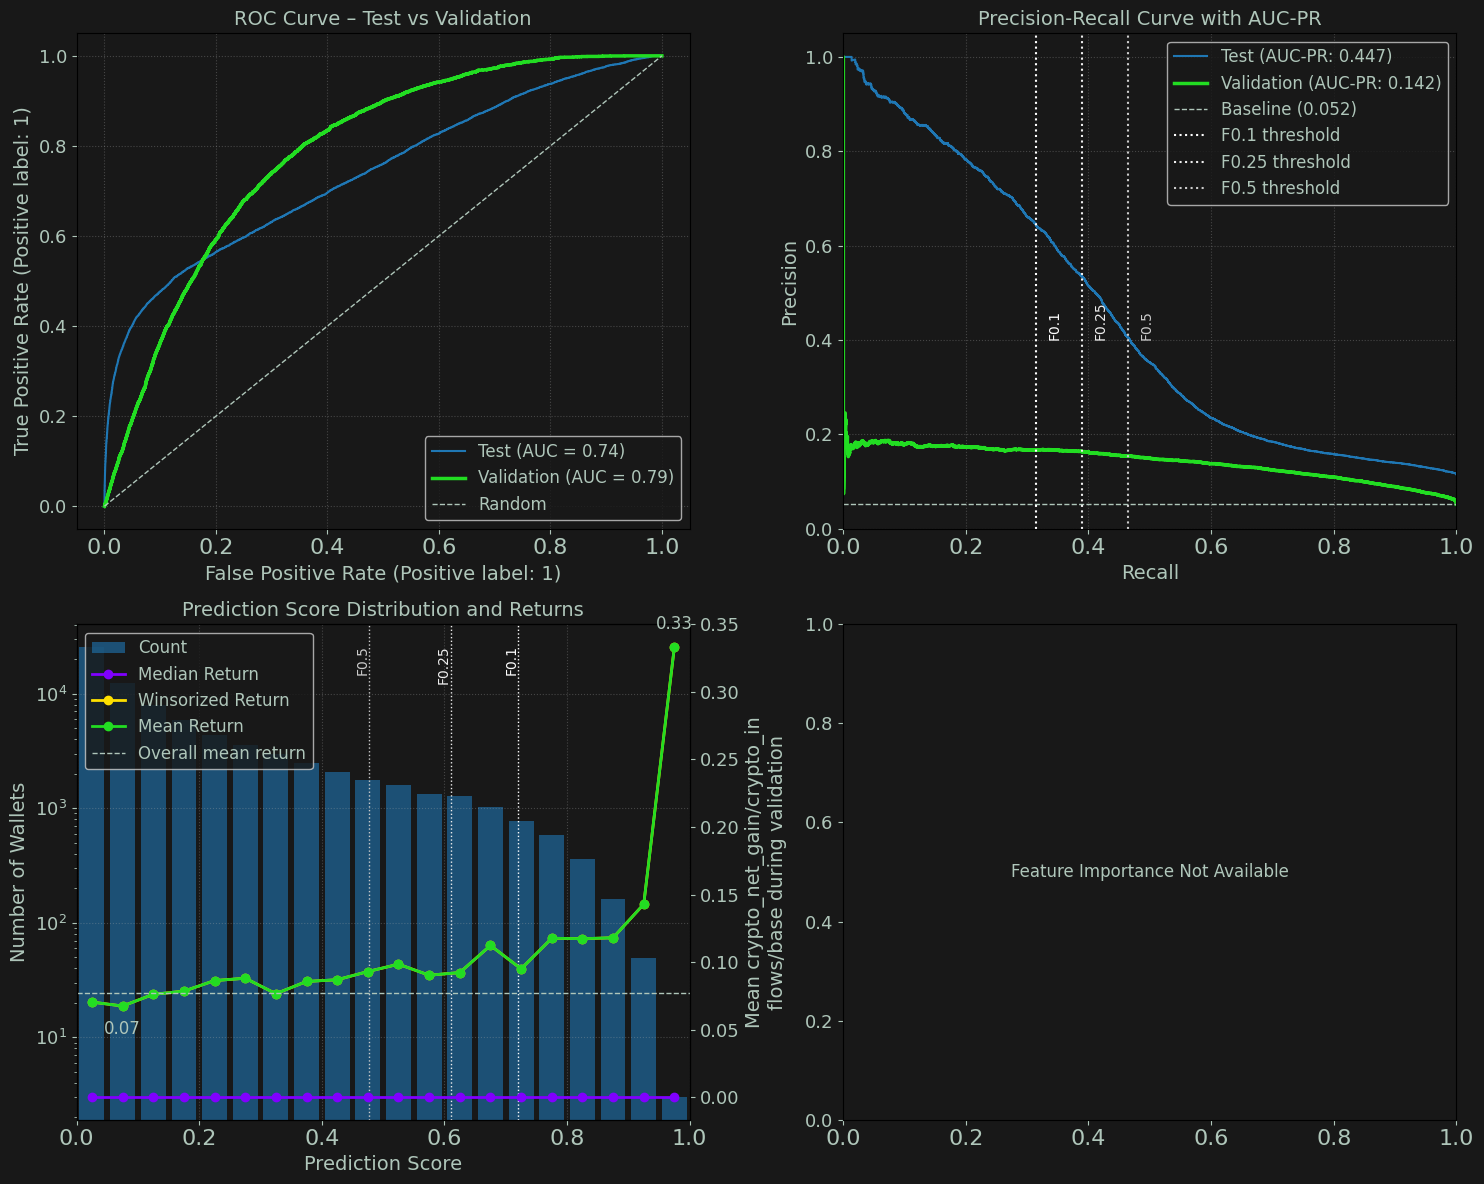

In [19]:
for e in evaluators:
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


[08/Aug/25 19:19:36] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:690] Building evaluators for 2 epoch shifts using 4 threads...
[08/Aug/25 19:19:37] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-190236): s3://wallet-script-models/model-outputs/dda-951-eval-all-dev/sh60/wscr-dda-951--sh60-0808-190236/output/model.tar.gz
[08/Aug/25 19:19:37] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-190236): s3://wallet-script-models/model-outputs/dda-951-eval-all-dev/sh0/wscr-dda-951--sh0-0808-190236/output/model.tar.gz


Unique offset_date values in data: [1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0]
Target offset_days after 60 shift: [1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650]
Unique offset_date values in data: [1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0]
Target offset_days after 60 shift: [1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650]
No custom filters configured, returning unfiltered data
Unique offset_date values in data: [1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0]
Target offset_days after 0 shift: [1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590]
Unique offset_date values in data: [1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0]
Target offset_days after 0 shift: [1290, 1320, 1350, 1380, 1410, 1440, 1470, 15

[08/Aug/25 19:19:38] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:707] ✓ Built evaluator for epoch_shift=60
[08/Aug/25 19:19:38] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:707] ✓ Built evaluator for epoch_shift=0


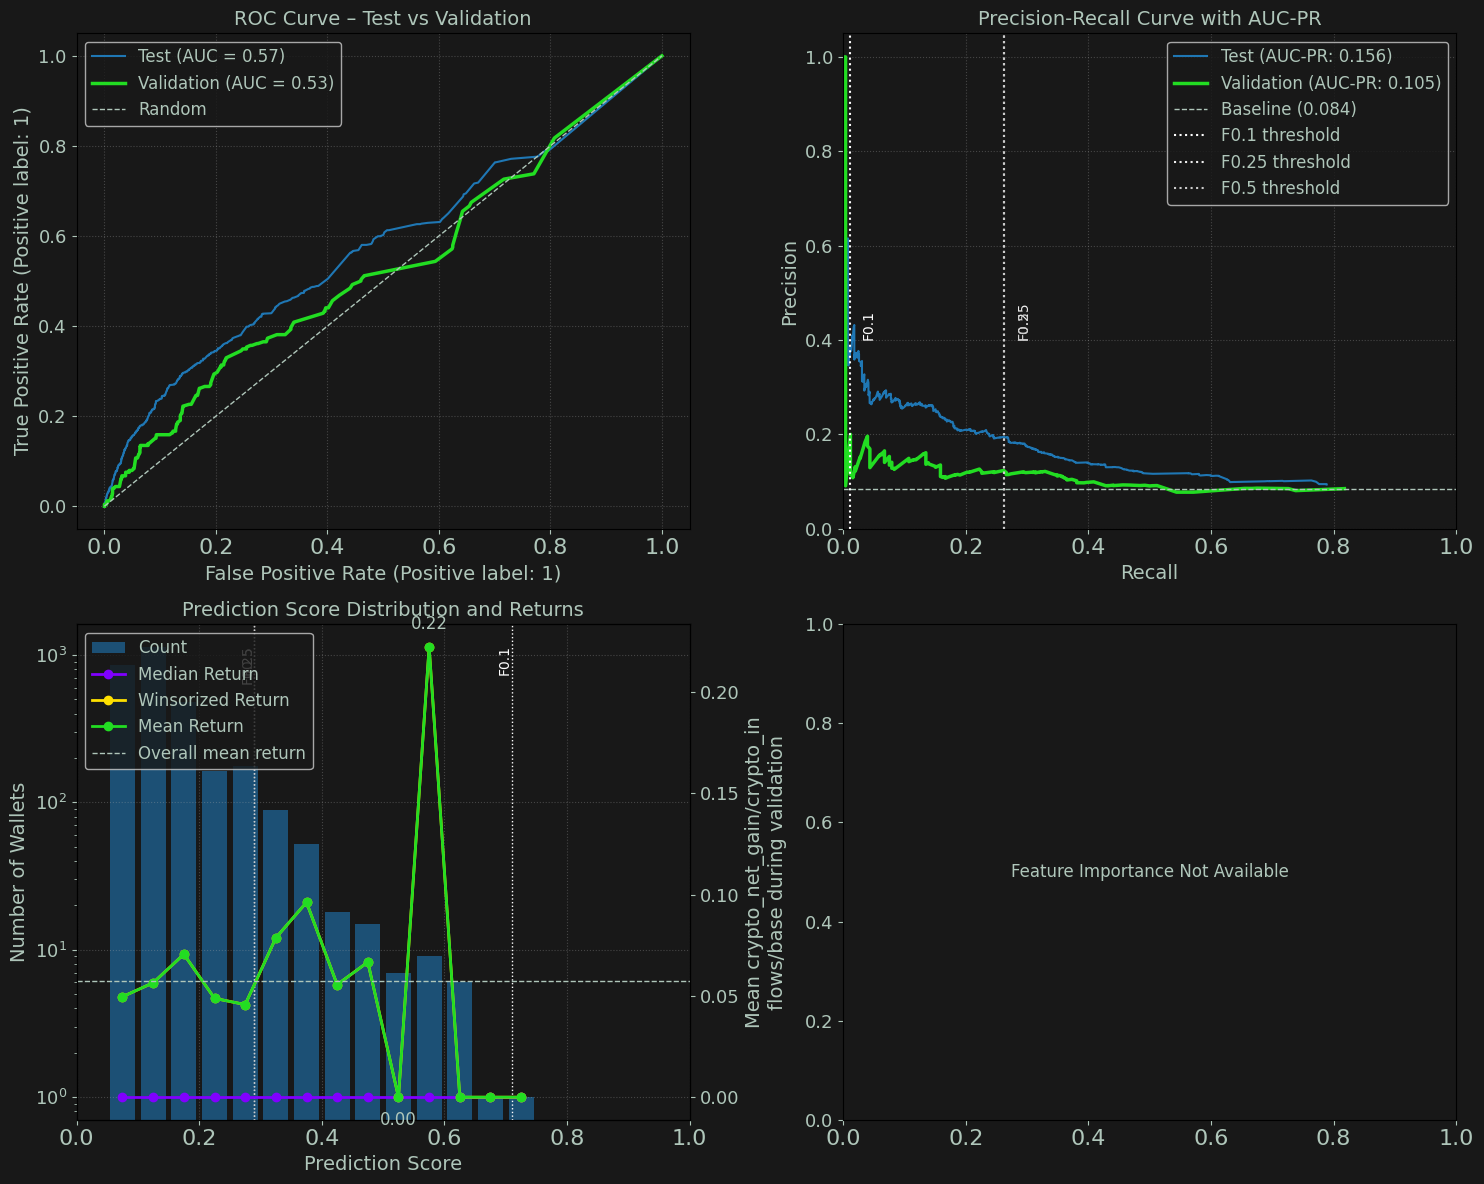

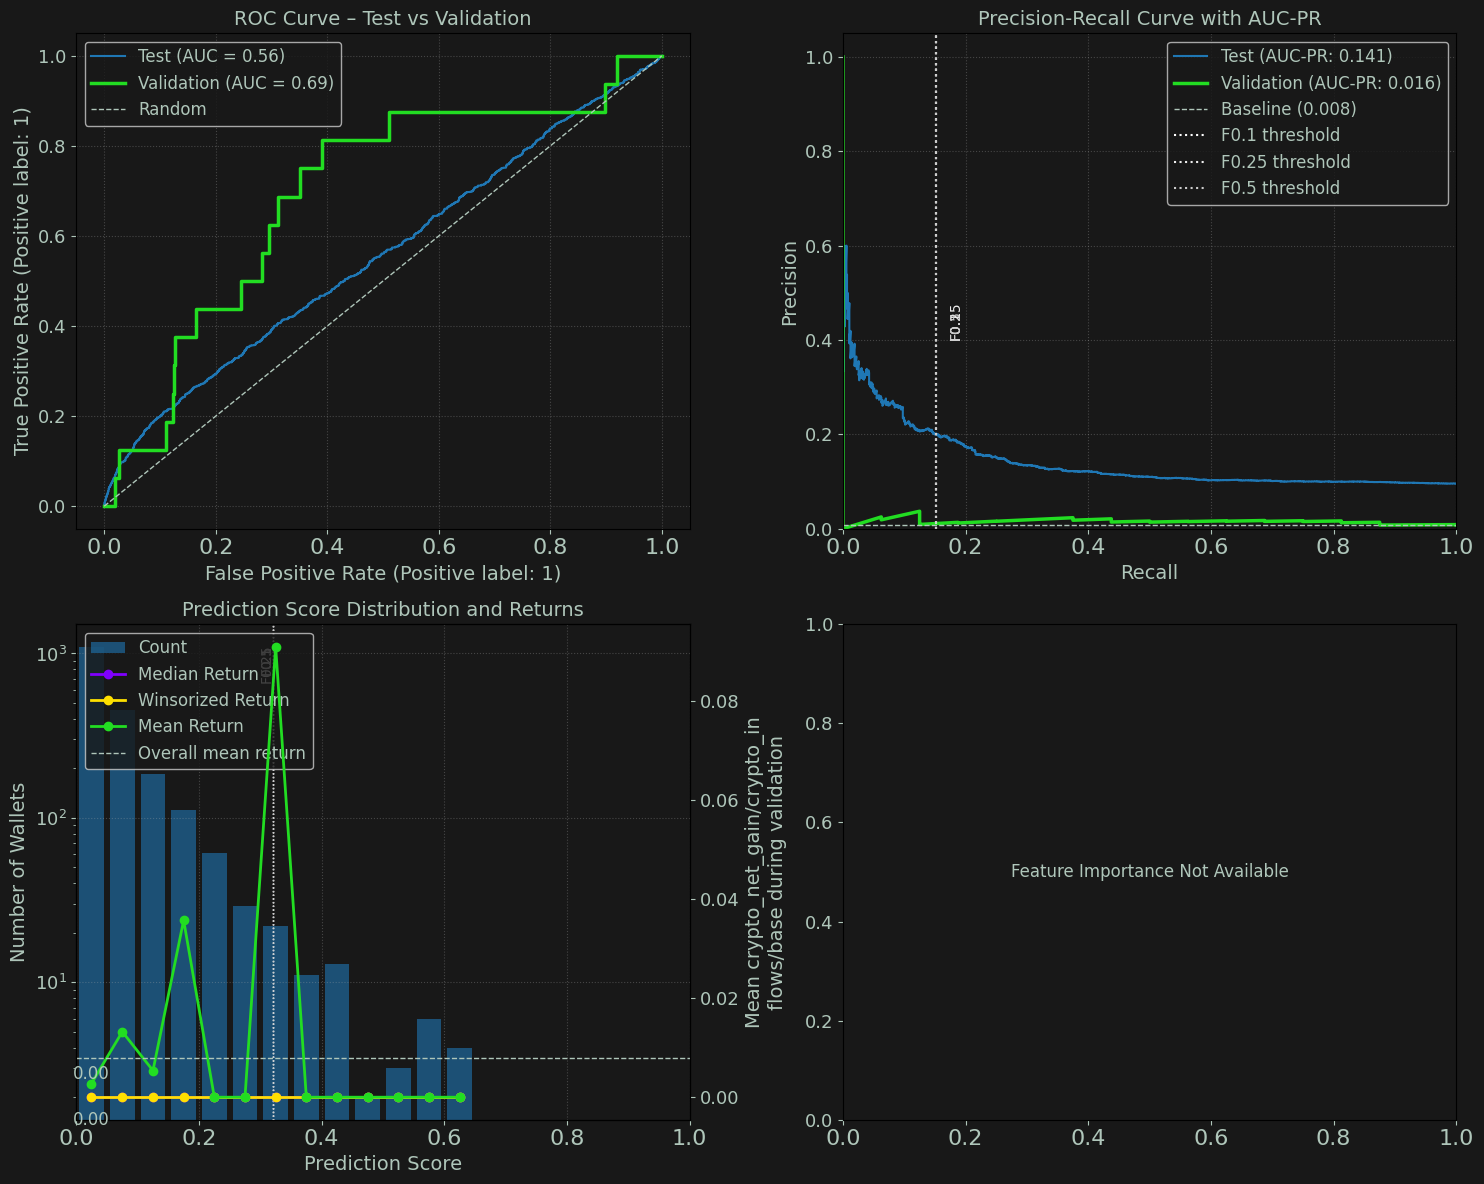

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = workflow_orch.build_all_epoch_shift_evaluators()


In [8]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

workflow_orch.predict_all_epoch_shifts()

[08/Aug/25 18:29:57] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:640] Starting predictions for 7 epoch shifts using 10 threads...
[08/Aug/25 18:29:58] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-182128): s3://wallet-script-models/model-outputs/dda-951-eval-all/sh240/wscr-dda-951--sh240-0808-182128/output/model.tar.gz
[08/Aug/25 18:29:58] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-182128): s3://wallet-script-models/model-outputs/dda-951-eval-all/sh-60/wscr-dda-951--sh-60-0808-182128/output/model.tar.gz
[08/Aug/25 18:29:58] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-182128): s3://wallet-script-models/model-outputs/dda-951-eval-all/sh0/wscr-dda-951--sh0-0808-182128/output/model.tar.gz
[08/Aug/25 18:29:58] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-1821

...

[08/Aug/25 18:30:06] WARNING [session.submit:4116] Using already existing model: wscr-dda-951--sh60-0808-182128
[08/Aug/25 18:30:06] INFO [wallet_modeler._execute_batch_transform:624] Starting batch transform job: wallet-scoring-sh60-183006-concat-val
[08/Aug/25 18:30:06] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh60-183006-concat-val


.

[08/Aug/25 18:30:09] WARNING [session.submit:4116] Using already existing model: wscr-dda-951--sh240-0808-182128
[08/Aug/25 18:30:10] INFO [wallet_modeler._execute_batch_transform:624] Starting batch transform job: wallet-scoring-sh240-183009-concat-val
[08/Aug/25 18:30:10] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh240-183009-concat-val


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!

[08/Aug/25 18:34:40] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh-60/wallet-scoring-sh-60-183004-concat-test/test.csv.out



..

[08/Aug/25 18:34:41] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh-60/test.csv.out.
[08/Aug/25 18:34:41] INFO [wallet_modeler.None:296] (4m42s) Completed predict_with_batch_transform.


...........................!

[08/Aug/25 18:34:54] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh240/wallet-scoring-sh240-182959-concat-test/test.csv.out



...

[08/Aug/25 18:34:54] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh240/test.csv.out.
[08/Aug/25 18:34:54] INFO [wallet_modeler.None:296] (4m56s) Completed predict_with_batch_transform.


..............................!

[08/Aug/25 18:35:11] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh0/wallet-scoring-sh0-183002-concat-test/test.csv.out



.

[08/Aug/25 18:35:11] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh0/test.csv.out.
[08/Aug/25 18:35:11] INFO [wallet_modeler.None:296] (5m13s) Completed predict_with_batch_transform.
[08/Aug/25 18:35:11] ERROR [workflow_orchestrator.predict_all_epoch_shifts:664] ✗ Failed predictions for epoch_shift=0: An error occurred (ThrottlingException) when calling the CreateModel operation (reached max retries: 4): Rate exceeded


.....!

[08/Aug/25 18:35:14] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh120/wallet-scoring-sh120-182959-concat-test/test.csv.out



..

[08/Aug/25 18:35:15] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh120/test.csv.out.
[08/Aug/25 18:35:15] INFO [wallet_modeler.None:296] (5m16s) Completed predict_with_batch_transform.
[08/Aug/25 18:35:15] ERROR [workflow_orchestrator.predict_all_epoch_shifts:664] ✗ Failed predictions for epoch_shift=120: An error occurred (ThrottlingException) when calling the CreateModel operation (reached max retries: 4): Rate exceeded


..!

[08/Aug/25 18:35:17] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh180/wallet-scoring-sh180-182959-concat-test/test.csv.out


[08/Aug/25 18:35:18] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh180/test.csv.out.
[08/Aug/25 18:35:18] INFO [wallet_modeler.None:296] (5m19s) Completed predict_with_batch_transform.


.........!

[08/Aug/25 18:35:24] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh300/wallet-scoring-sh300-183004-concat-test/test.csv.out



..

[08/Aug/25 18:35:25] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh300/test.csv.out.
[08/Aug/25 18:35:25] INFO [wallet_modeler.None:296] (5m26s) Completed predict_with_batch_transform.


....!

[08/Aug/25 18:35:30] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh60/wallet-scoring-sh60-183002-concat-test/test.csv.out



.

[08/Aug/25 18:35:30] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh60/test.csv.out.
[08/Aug/25 18:35:30] INFO [wallet_modeler.None:296] (5m31s) Completed predict_with_batch_transform.


..................!

[08/Aug/25 18:35:49] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh-60/wallet-scoring-sh-60-182959-concat-val/val.csv.out



.

[08/Aug/25 18:35:50] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh-60/val.csv.out.
[08/Aug/25 18:35:50] INFO [wallet_modeler.None:296] (5m52s) Completed predict_with_batch_transform.
[08/Aug/25 18:35:50] INFO [wallet_modeler.None:351] (5m52s) Completed batch_predict_test_and_val.
[08/Aug/25 18:35:50] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:662] ✓ Completed predictions for epoch_shift=-60


....!

[08/Aug/25 18:35:56] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh60/wallet-scoring-sh60-183006-concat-val/val.csv.out


[08/Aug/25 18:35:57] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh60/val.csv.out.
[08/Aug/25 18:35:57] INFO [wallet_modeler.None:296] (5m59s) Completed predict_with_batch_transform.
[08/Aug/25 18:35:57] INFO [wallet_modeler.None:351] (5m59s) Completed batch_predict_test_and_val.
[08/Aug/25 18:35:57] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:662] ✓ Completed predictions for epoch_shift=60


!

[08/Aug/25 18:35:58] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh180/wallet-scoring-sh180-183004-concat-val/val.csv.out


[08/Aug/25 18:35:59] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh180/val.csv.out.
[08/Aug/25 18:35:59] INFO [wallet_modeler.None:296] (6m0s) Completed predict_with_batch_transform.
[08/Aug/25 18:35:59] INFO [wallet_modeler.None:351] (6m0s) Completed batch_predict_test_and_val.
[08/Aug/25 18:35:59] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:662] ✓ Completed predictions for epoch_shift=180


..!

[08/Aug/25 18:36:05] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh300/wallet-scoring-sh300-182959-concat-val/val.csv.out



!

[08/Aug/25 18:36:05] INFO [wallet_modeler._execute_batch_transform:641] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh240/wallet-scoring-sh240-183009-concat-val/val.csv.out
[08/Aug/25 18:36:05] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh300/val.csv.out.
[08/Aug/25 18:36:05] INFO [wallet_modeler.None:296] (6m7s) Completed predict_with_batch_transform.
[08/Aug/25 18:36:05] INFO [wallet_modeler.None:351] (6m7s) Completed batch_predict_test_and_val.
[08/Aug/25 18:36:05] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:662] ✓ Completed predictions for epoch_shift=300


[08/Aug/25 18:36:06] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all/sh240/val.csv.out.
[08/Aug/25 18:36:06] INFO [wallet_modeler.None:296] (6m7s) Completed predict_with_batch_transform.
[08/Aug/25 18:36:06] INFO [wallet_modeler.None:351] (6m7s) Completed batch_predict_test_and_val.
[08/Aug/25 18:36:06] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:662] ✓ Completed predictions for epoch_shift=240
[08/Aug/25 18:36:06] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:669] Epoch shift predictions complete: 5/7 successful


{0: {'error': 'An error occurred (ThrottlingException) when calling the CreateModel operation (reached max retries: 4): Rate exceeded'},
 120: {'error': 'An error occurred (ThrottlingException) when calling the CreateModel operation (reached max retries: 4): Rate exceeded'},
 -60: {'test': {'transform_job_name': 'wallet-scoring-sh-60-183004-concat-test',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh-60/wallet-scoring-sh-60-183004-concat-test/test.csv.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-951-eval-all/test.csv'},
  'val': {'transform_job_name': 'wallet-scoring-sh-60-182959-concat-val',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-951-eval-all/sh-60/wallet-scoring-sh-60-182959-concat-val/val.csv.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-951-eval-all/val.csv'},
  'model_uri': 's3://wallet-script-models/model-outputs/dda-951-

### evaluate all epoch_shifts

In [19]:
evaluators[-60].summary_report()

[08/Aug/25 18:42:44] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base 0.4 to 
ID: s3://wallet-script-models/model-outputs/dda-951-eval-all/sh-60/wscr-dda-951--sh-60-0808-182128/output/model.tar.gz
Test Samples:             32,885
Val Positive Samples:     1,931 (2.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.281  |  0.330
Val Accuracy:               0.980  |  0.887
Val Precision:              0.000  |  0.000
Val Recall:                 0.000  |  0.000
Val F1 Score:               0.000  |  0.000

Validation Returns    | Cutoff |  Mean   |  W-Mean
--------------------------------------------------
Overall Average       |    n/a |   0.020 |   0.020
Param Threshold       |   0.80 |     nan |     nan
5 Highest Scores      |   0.54 |   0.000 |   0.000
Top 1% Scores         |   0.30 |   0.004 |   

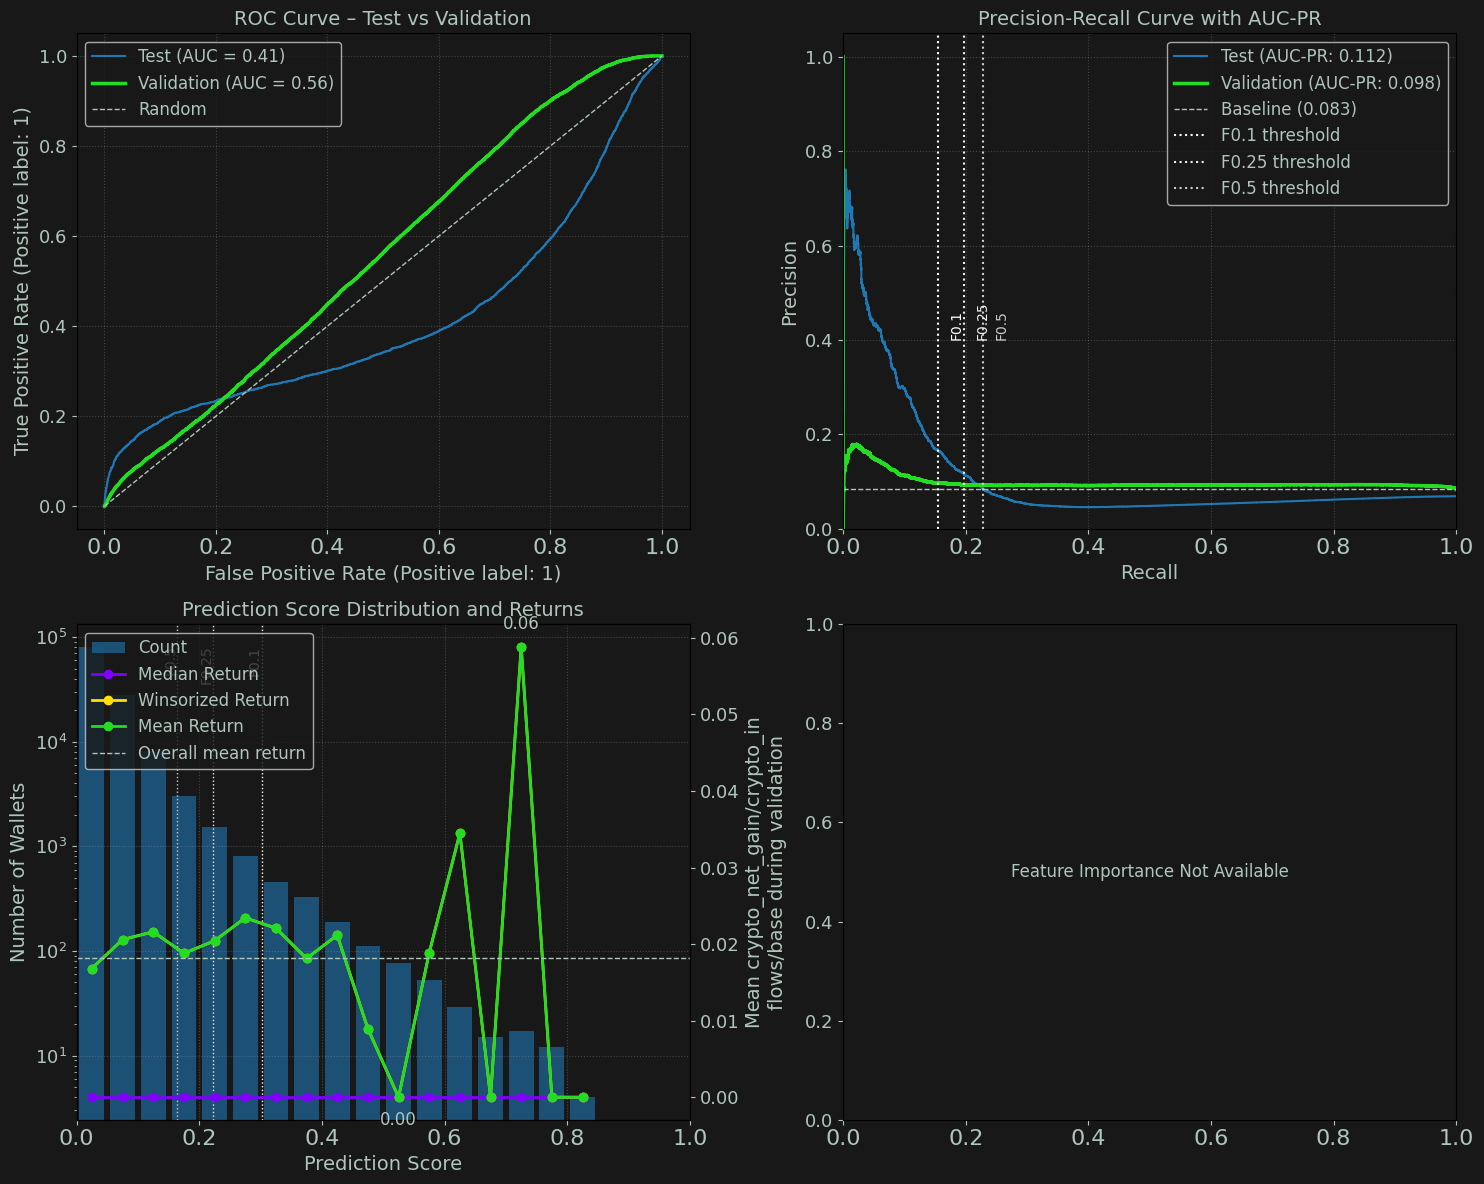

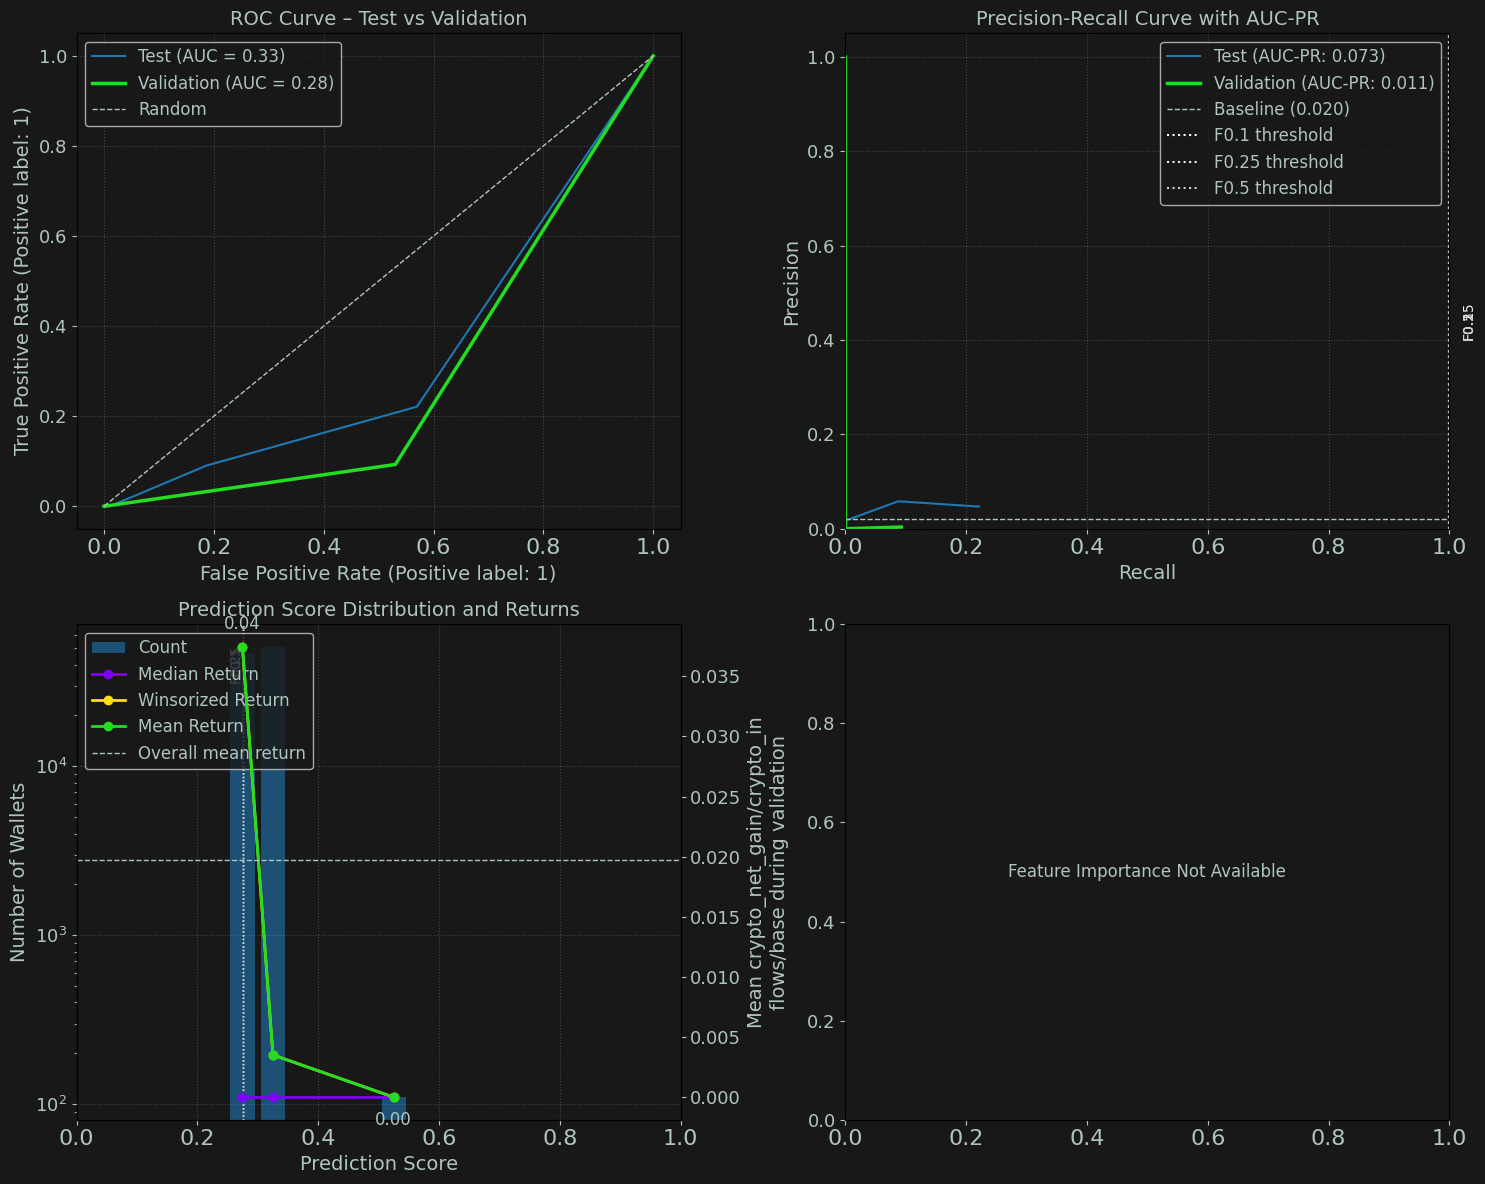

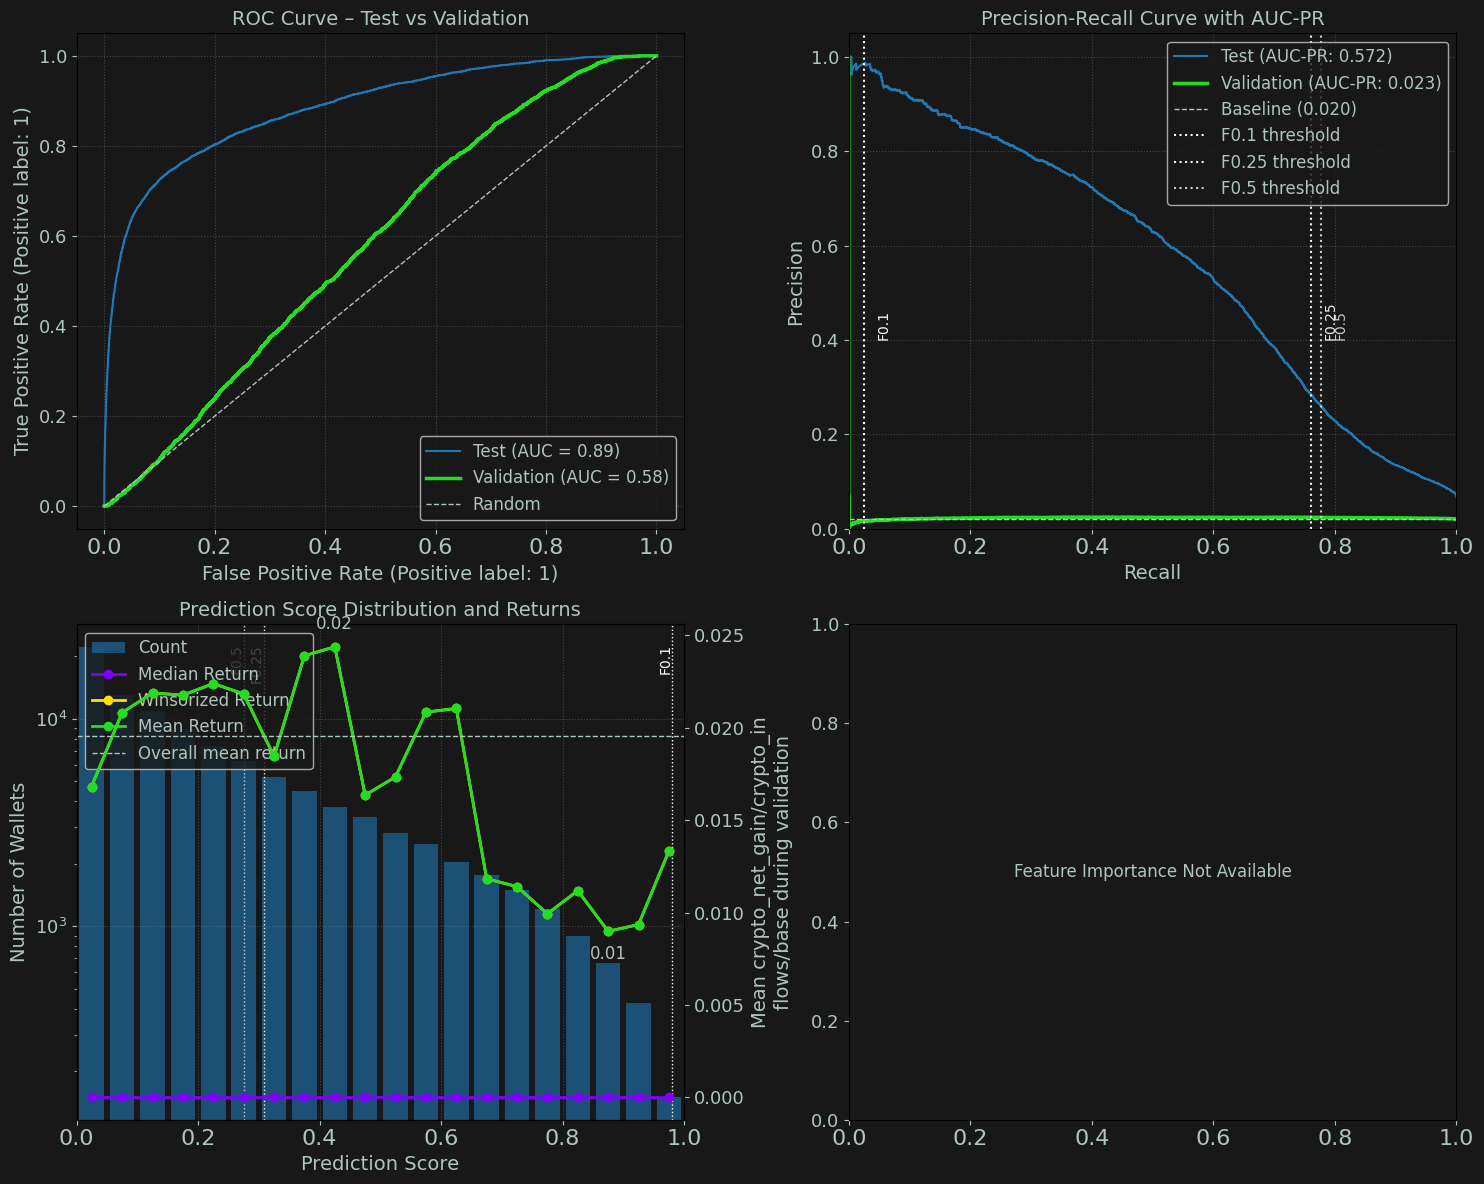

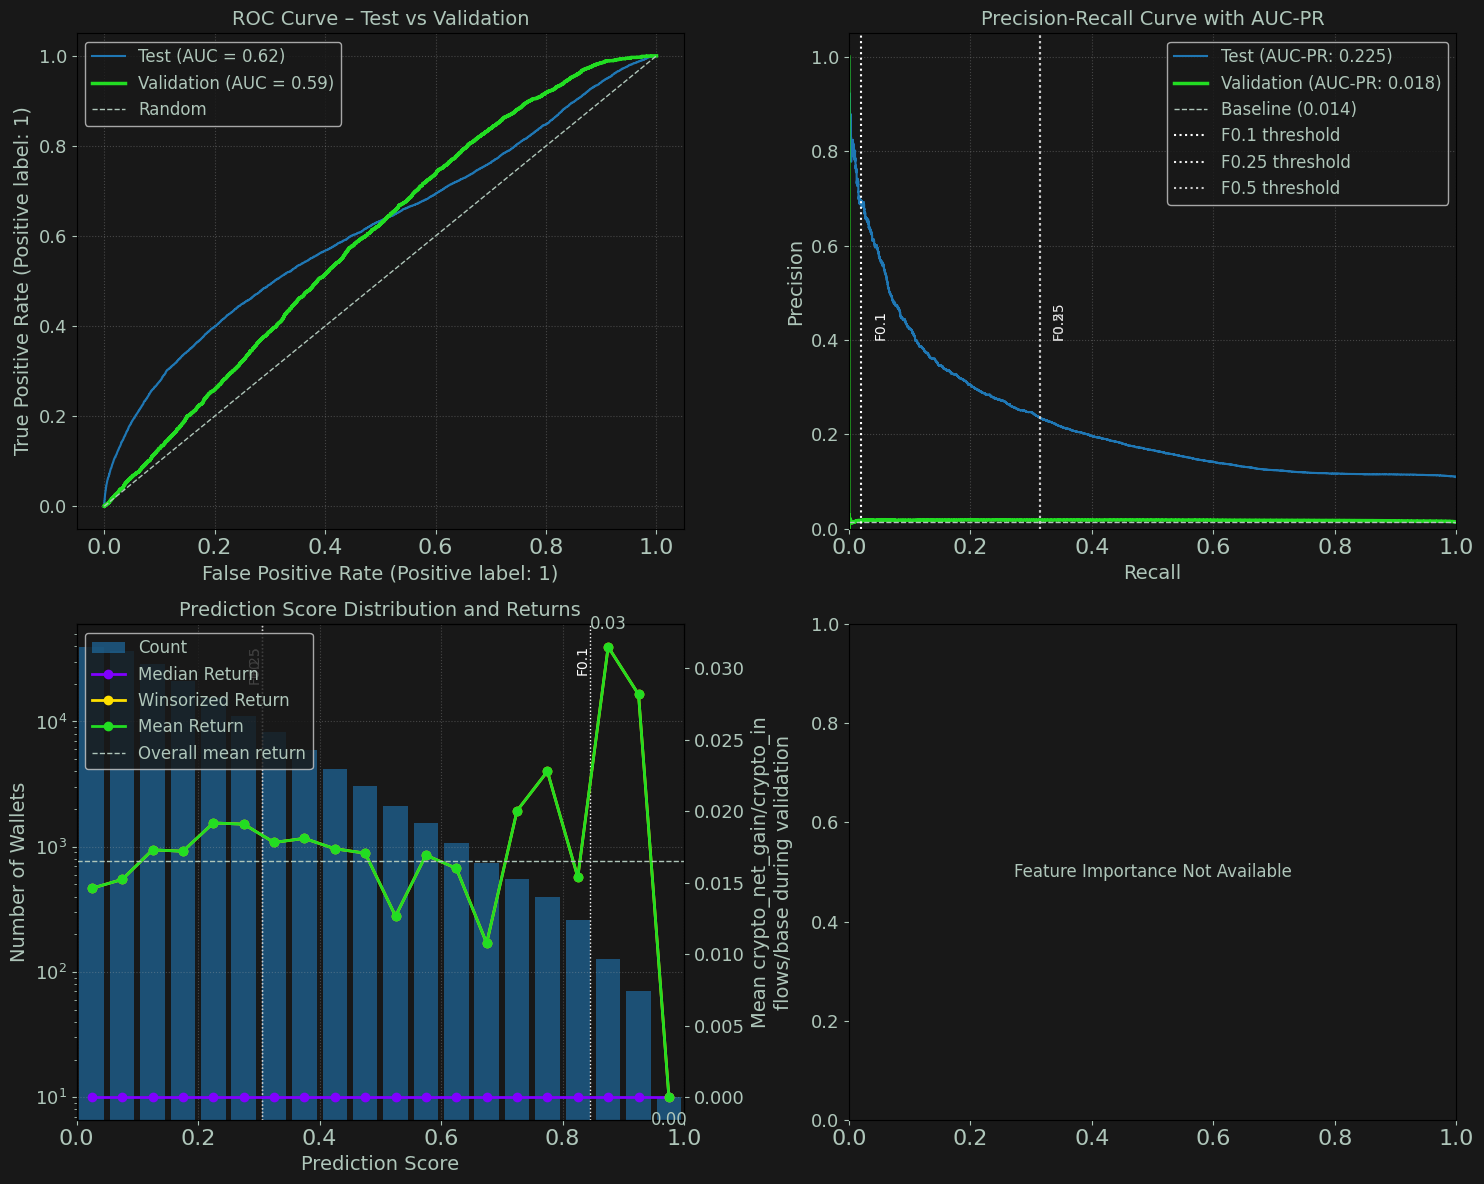

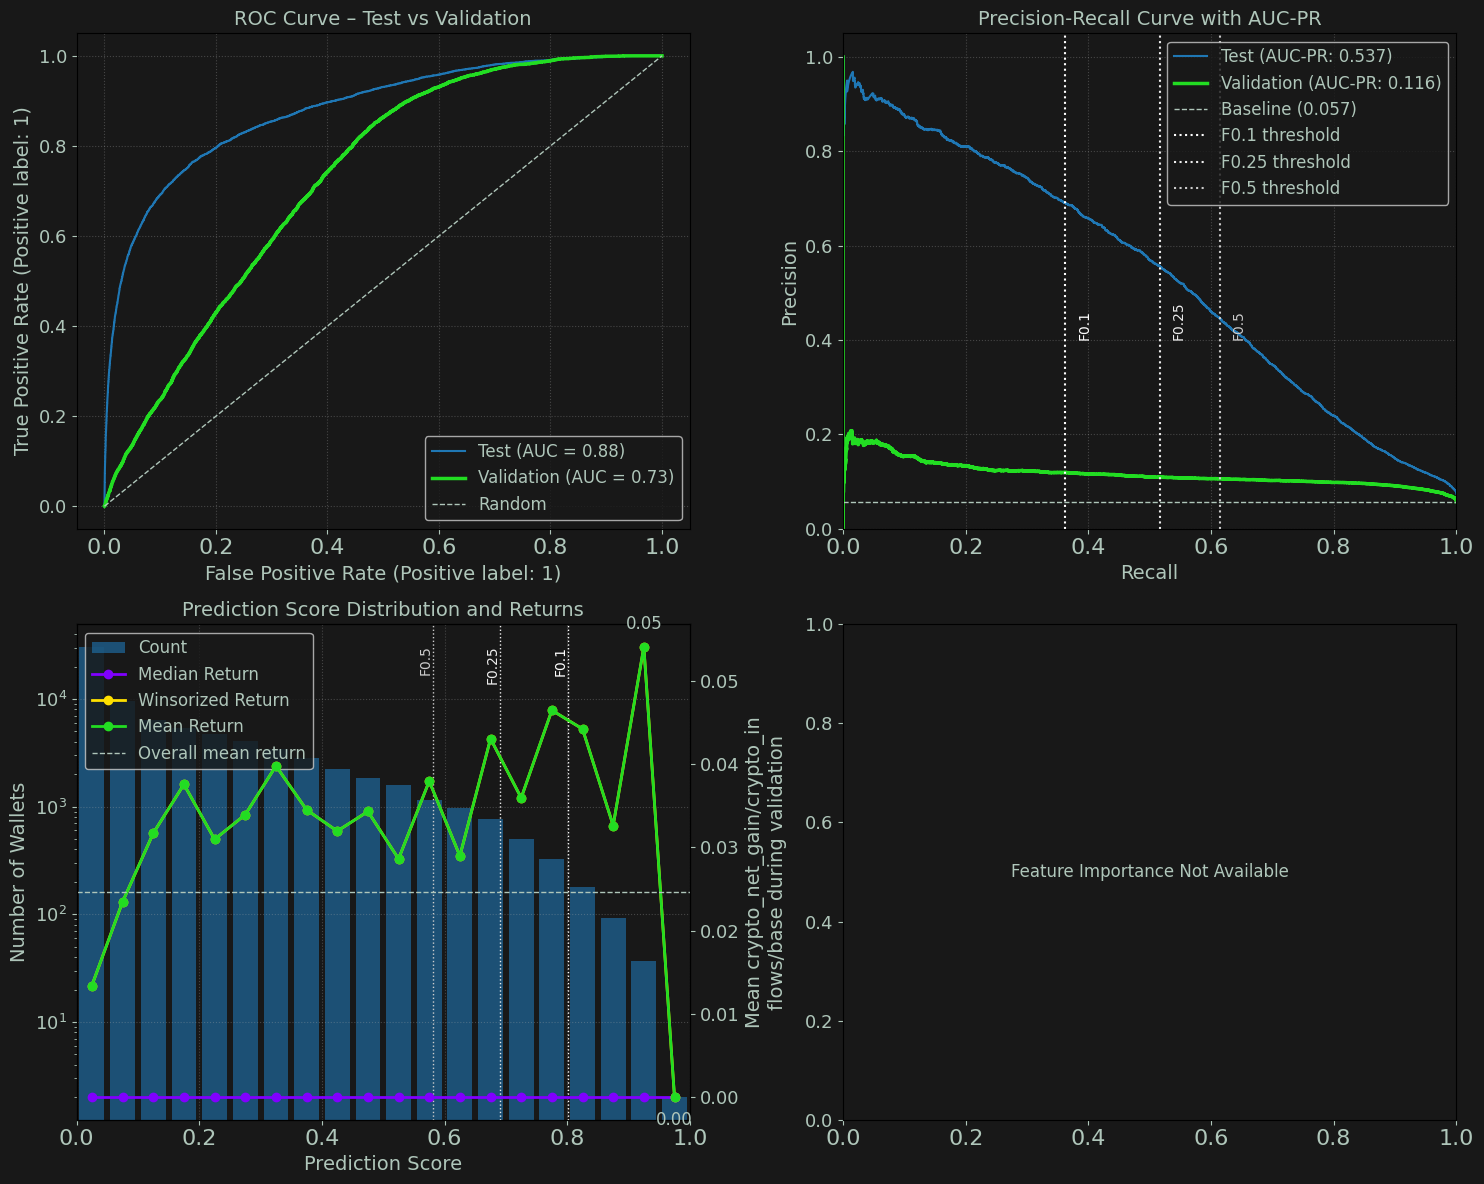

In [17]:
for e in evaluators:
    evaluators[e].plot_wallet_evaluation()


In [30]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = workflow_orch.build_all_epoch_shift_evaluators()
for e in evaluators:
    evaluators[e].plot_wallet_evaluation()


[08/Aug/25 19:10:28] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:690] Building evaluators for 2 epoch shifts using 4 threads...


[08/Aug/25 19:10:29] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-190236): s3://wallet-script-models/model-outputs/dda-951-eval-all-dev/sh60/wscr-dda-951--sh60-0808-190236/output/model.tar.gz
[08/Aug/25 19:10:29] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-190236): s3://wallet-script-models/model-outputs/dda-951-eval-all-dev/sh0/wscr-dda-951--sh0-0808-190236/output/model.tar.gz
[08/Aug/25 19:10:29] ERROR [workflow_orchestrator.build_all_epoch_shift_evaluators:709] ✗ Failed to build evaluator for epoch_shift=60: [Errno 2] No such file or directory: '../s3_uploads/wallet_training_data_concatenated/dda_951_eval_all_dev/test.csv'
[08/Aug/25 19:10:29] ERROR [workflow_orchestrator.build_all_epoch_shift_evaluators:709] ✗ Failed to build evaluator for epoch_shift=0: [Errno 2] No such file or directory: '../s3_uploads/wallet_training_data_concatenated/dda_951_eval_all_dev/test.csv'


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_    │
│    7 evaluators = workflow_orch.build_all_epoch_shift_evaluators()                               │
│    8 for e in evaluators:                                                                        │
│ ❱  9 │   evaluators[e].plot_wallet_evaluation()                                                  │
│   10                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'dict' object has no attribute 'plot_wallet_evaluation'

In [10]:
evaluators


{120: {'error': "[Errno 2] No such file or directory: '../s3_downloads/wallet_predictions/dda_951_eval_all/sh120/val.csv.out'"},
 0: {'error': "[Errno 2] No such file or directory: '../s3_downloads/wallet_predictions/dda_951_eval_all/sh0/val.csv.out'"},
 60: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x368c8a610>,
 -60: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x373871790>,
 240: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x35d132010>,
 180: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x369e7b850>,
 300: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x3a72d2690>}

#### predict and filter data by epoch_shift

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

# Create modeler with epoch_shift as the date_suffix
shift_s3_uris = {f'sh{epoch_shift}': s3_uris['concat']}
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix=f'sh{epoch_shift}',
    s3_uris=shift_s3_uris,
    override_approvals=None
)

# Load the existing concatenated model
model_info = concat_modeler.load_existing_model(epoch_shift=epoch_shift)

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

date_suffix = f'sh{epoch_shift}'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
    epoch_shift
)

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


### Single Model Sequence

#### train

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_concatenated_offsets_model(concat_uris)

#### evaluate HPO outcomes

In [ ]:
player = u.AmbientPlayer()
player.stop_all_players()

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.get_hpo_results('concat')

In [ ]:
# Get the best hyperparameters
best_params = modeling_results['tuner'].best_training_job()

# Or more detailed info
analytics = modeling_results['tuner'].analytics()
best_job_df = analytics.dataframe()

# The best parameters are in the hyperparameters columns
print(best_params)
print(best_job_df.loc[0, ['eta', 'max_depth', 'subsample', 'FinalObjectiveValue']])

#### load existing model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

# Create modeler with 'concat' as the date_suffix
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix='concat',
    s3_uris=s3_uris,
    override_approvals=None
)

# Step 2: Load the existing concatenated model
model_info = concat_modeler.load_existing_model(modeling_results['model_uri'])


In [ ]:
model_info

#### predict

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

pred_results = concat_modeler.batch_predict_test_and_val()

#### evaluate

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

date_suffix = 'concat'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
)

In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 mktcap 20M-4B
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, inflows $5k
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


## Temporal cv model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '241101',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

In [ ]:
sm.train_temporal_cv_script_model(sage_wallets_config,sage_wallets_modeling_config,cv_s3_uri)

### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

# Model Evaluation

### Analyze predictions

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [ ]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

In [ ]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [ ]:
evaluator.y_validation

In [ ]:
evaluator.y_validation_pred_proba

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable